In [1]:
saveNames='siameseUnet-nomask-affine'

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "0,1,2,3" #change to the number of gpu's you want
# os.environ["CUDA_VISIBLE_DEVICES"]= "4,5,6,7" #change to the number of gpu's you want

In [3]:
import keras

Using TensorFlow backend.


In [4]:
import pickle

In [5]:
from keras import backend as K
K.set_image_dim_ordering('th')

In [6]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input, Flatten, Activation, Subtract, Multiply
from keras.layers import Conv3D, MaxPooling3D, Dropout, Concatenate, Dense, AveragePooling3D, AveragePooling2D, BatchNormalization, UpSampling3D, GlobalAveragePooling2D, GlobalAveragePooling3D
from keras.layers import Lambda, Reshape
from keras import regularizers
import nibabel as nib
from pathlib import Path #req python 3.4
import scipy.misc
import os.path
from tqdm import tqdm
from scipy.ndimage import affine_transform
import numpy
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import sys
import math

In [7]:
#https://stackoverflow.com/questions/44810826/how-to-share-convolution-kernels-between-layers-in-keras

i1=Input(shape=(1,64,64,64)) #tgt
i2=Input(shape=(1,64,64,64)) #src

s1= Conv3D(16, 3 ,padding='same')#second conv 
s2= Conv3D(16, 3 ,padding='same')#second conv 
s3= Conv3D(16, 3 ,padding='same')#second conv 
s4= Conv3D(16, 3 ,padding='same')#second conv 
#these 2 are layer 1
d1= Conv3D(16, 3,padding='same')#first conv 
d2= Conv3D(32, 3 ,padding='same')#second conv 
d3= Conv3D(32, 3, padding='same')
d4= Conv3D(32, 3, padding='same')
d5= Conv3D(32, 3, padding='same')

u1= Conv3D(32, 3, padding='same')
u2= Conv3D(32, 3, padding='same')
u3= Conv3D(32, 3, padding='same')
u4= Conv3D(32, 3,padding='same')
u5= Conv3D(32, 3,padding='same')
u6= Conv3D(16, 3,padding='same')
u7= Conv3D(12, 1,padding='same', use_bias=False)

slay1=s1(i1)
slay1=BatchNormalization()(slay1) #not enough memory to batchnorm
slay1=Activation('relu')(slay1)
slay1=s2(slay1)
slay1=BatchNormalization()(slay1) #not enough memory to batchnorm
slay1=Activation('relu')(slay1)
slay1=s3(slay1)
slay1=BatchNormalization()(slay1) #not enough memory to batchnorm
slay1=Activation('relu')(slay1)
slay1=s4(slay1)
slay1=BatchNormalization()(slay1) #not enough memory to batchnorm
slay1=Activation('relu')(slay1)

slay2=s1(i2)
slay2=BatchNormalization()(slay2) #not enough memory to batchnorm
slay2=Activation('relu')(slay2)
slay2=s2(slay2)
slay2=BatchNormalization()(slay2) #not enough memory to batchnorm
slay2=Activation('relu')(slay2)
slay2=s3(slay2)
slay2=BatchNormalization()(slay2) #not enough memory to batchnorm
slay2=Activation('relu')(slay2)
slay2=s4(slay2)
slay2=BatchNormalization()(slay2) #not enough memory to batchnorm
slay2=Activation('relu')(slay2)

con=Concatenate(axis=1)([slay1,slay2]) 
d256=d1(con)
d256=BatchNormalization()(d256) #not enough memory to batchnorm
d256=Activation('relu')(d256)
d128=MaxPooling3D(pool_size=(2,2,2))(d256)
d128=d2(d128)
d128=BatchNormalization()(d128)
d128=Activation('relu')(d128)
d64=MaxPooling3D(pool_size=(2,2,2))(d128)
d64=d3(d64)
d64=BatchNormalization()(d64)
d64=Activation('relu')(d64)
d32=MaxPooling3D(pool_size=(2,2,2))(d64)
d32=d4(d32)
d32=BatchNormalization()(d32)
d32=Activation('relu')(d32)
d16=MaxPooling3D(pool_size=(2,2,2))(d32)
d16=d5(d16)
d16=BatchNormalization()(d16)
# d16=Activation('relu')(d16)
#smallest layer ends here
u32=UpSampling3D()(d16)
u32=Concatenate(axis=1)([u32,d32]) 
u32=u1(u32)
u32=BatchNormalization()(u32)
# u32=Activation('relu')(u32)
u64=UpSampling3D()(u32)
u64=Concatenate(axis=1)([u64,d64]) 
u64=u2(u64)
u64=BatchNormalization()(u64)
# u64=Activation('relu')(u64)
u128=UpSampling3D()(u64)
u128=Concatenate(axis=1)([u128,d128]) 
u128=u3(u128)
u128=BatchNormalization()(u128)
# u128=Activation('relu')(u128)
u256=UpSampling3D()(u128)
u256=Concatenate(axis=1)([u256,d256]) 
u256=u4(u256)
u256=BatchNormalization()(u256)
# u256=Activation('relu')(u256)
maskfeed=u5(u256)
fout=u7(maskfeed)
fout=GlobalAveragePooling3D()(fout)

model=Model(inputs=[i1, i2],outputs=fout)
# opt=keras.optimizers.Adam(lr=0.0001)
# opt=keras.optimizers.Adam(lr=0.0005)
opt=keras.optimizers.Adam(lr=0.001) #performs ok on the 3 layer->concat->2 layers of (conv->bn->relu)->dense, batch size 4
# opt=keras.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999) #adam defaults to b1=0.9, b2=0.999
# opt=keras.optimizers.Adam(lr=0.01) # 10x default learn rate
# opt=keras.optimizers.Adadelta() # using the default hyperparams, this thing even after 1k brains of training, still predicts random warps
model.compile(optimizer=opt,loss='mean_squared_error')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1, 64, 64, 64 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1, 64, 64, 64 0                                            
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 16, 64, 64, 6 448         input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 16, 64, 64, 6 256         conv3d_1[0][0]                   
__________

In [8]:
#validation test dataset:
transforms = numpy.genfromtxt('rand_affine_transforms_small_5std_0mu_01std_0mu.csv', delimiter=',')
i=0
p = Path('/nfs01/data/FS_Slim/MCIC') #brains
testDirectories = [x for x in p.iterdir() if x.is_dir()]
vSize=4 #4 pairs of images
inBatch=0
testThestas=transforms[-(vSize):]
nameString='saved_small_brains/MCIC-small-test-std5-mu0-64-'
while inBatch<vSize:
    fname1 = str(testDirectories[i])+'/mri/norm.mgz'
    if os.path.isfile(fname1):
        scan = numpy.array(nib.load(fname1).get_data())[::4,::4,::4]
        if numpy.count_nonzero(scan)!=0: # make sure skull strip is not blank
            inBatch+=1
            #have i already transformed this before?
            if os.path.isfile(nameString+str(inBatch)+'.npy'):
                aScan=numpy.load(nameString+str(inBatch)+'.npy')
            else:
                warp=[transforms[i,0:3],transforms[i,4:7],testThestas[i,8:11]]
                aScan=affine_transform(scan,warp, offset=testThestas[i,3:15:4])
                aScan=numpy.expand_dims(numpy.expand_dims(aScan, axis=0), axis=0)
                #we're gonna save the warp numpy 3d array to save some time later
                numpy.save(nameString+str(inBatch),aScan)
            if inBatch==1:
                v2=aScan
            else:
                v2=numpy.append(v2,aScan,axis=0)
            scan=numpy.expand_dims(numpy.expand_dims(scan, axis=0), axis=0)
            if inBatch==1:
                v1=scan
            else:
                v1=numpy.append(v1,scan, axis=0)
    i+=1


In [20]:
# generate random affine transforms
import csv 
num=1000000
mu, sigma = 1, 0.1 # diagonals of the affine transform
d = numpy.random.normal(mu, sigma, 3*num) # 3 columns of 10k ##INCREASED
mu, sigma = 5, 5 # offsets
o = numpy.random.normal(mu, sigma, 3*num) # 3 columns of 10k ## STAYS THE SAME
mu, sigma = 0, 0.1 # others
others = numpy.random.normal(mu, sigma, 6*num) # 6 columns of 10k ##INCREASED
with open('rand_affine_transforms_small_5std_5mu.csv','w',newline='') as csvfile:
    writer = csv.writer(csvfile,delimiter = ',')
    for row in range(num):
        writer.writerow([d[row],others[row],others[row+num],o[row],others[row+2*num],d[row+num],others[row+3*num],o[row+num],others[row+4*num],others[row+5*num],d[row+2*num],o[row+2*num]])

In [11]:
# generate random affine transforms
import csv 
num=1000000
mu, sigma = 1, 0.1 # diagonals of the affine transform
d = numpy.random.normal(mu, sigma, 3*num) # 3 columns of 10k ##INCREASED
mu, sigma = 0, 5 # offsets
o = numpy.random.normal(mu, sigma, 3*num) # 3 columns of 10k ## STAYS THE SAME
mu, sigma = 0, 0.1 # others
others = numpy.random.normal(mu, sigma, 6*num) # 6 columns of 10k ##INCREASED
with open('rand_affine_transforms_small_5std_0mu_01std_0mu.csv','w',newline='') as csvfile:
    writer = csv.writer(csvfile,delimiter = ',')
    for row in range(num):
        writer.writerow([d[row],others[row],others[row+num],o[row],others[row+2*num],d[row+num],others[row+3*num],o[row+num],others[row+4*num],others[row+5*num],d[row+2*num],o[row+2*num]])

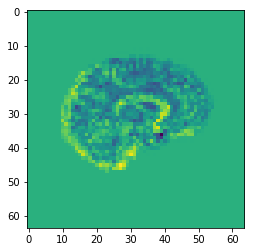

In [14]:
plt.imshow(bScan[0,0,32,...].astype('float')-bAffScan[0,0,32,...].astype('float'))

In [53]:
#read in the transforms; this should only be 7 mB
warpname='rand_affine_transforms_small_5std_0mu_01std_0mu'
transforms = numpy.genfromtxt(warpname+'.csv', delimiter=',') 
#throw these pieces in a script.py to do real training
# epoch here will be defined as the abide dataset
efilename='efile-'+saveNames+'.txt'
pfilename='pfile-'+saveNames+'.txt'
tfilename='tfile-'+saveNames+'.txt'
predictionsPlot=[]
truthsPlot=[]
errorPlot=[]
testErrors=[]
batchSize=8
tIndex=0
# crop=[25:-25,25:-25,25:-25]
#validation test dataset:
p = Path('/nfs01/data/FS_Slim/MCIC') #brains
testDirectories = [x for x in p.iterdir() if x.is_dir()]
for epoch in tqdm(range(100)):
    for dSet in range(3):
        i=0
        totalError=0
        batchNum=0
        numInBatch=0
        if dSet==0: ##brains must be pulled out of saved_brains in this order otherwise the thetas will not be aligned
            p = Path('/nfs01/data/FS_Slim/ABIDE') #brains
            subdirectories = [x for x in p.iterdir() if x.is_dir()]
            nameString='saved_small_brains/ABIDE-std5-mu0-64-'
        if dSet==1:
            p = Path('/nfs01/data/FS_Slim/ADHD200') 
            subdirectories = [x for x in p.iterdir() if x.is_dir()]
            nameString='saved_small_brains/ADHD200-std5-mu0-64-'
        if dSet==2:
            p = Path('/nfs01/data/FS_Slim/PPMI') 
            subdirectories = [x for x in p.iterdir() if x.is_dir()]
            nameString='saved_small_brains/PPMI-std5-mu0-64-'
        while i < len(subdirectories):
            fname1 = str(subdirectories[i])+'/mri/norm.mgz'
            if os.path.isfile(fname1):
                tIndex+=1
                if os.path.isfile(nameString+str(tIndex)+'-normal'+'.npy'):
                    scan=numpy.load(nameString+str(tIndex)+'-normal'+'.npy')
                else:
                    scan = numpy.array(nib.load(fname1).get_data())[::4,::4,::4]
                if numpy.count_nonzero(scan)!=0: # make sure skull strip is not blank
                    if not os.path.isfile(nameString+str(tIndex)+'-normal'+'.npy'):
                        numpy.save(nameString+str(tIndex)+'-normal'+'.npy', scan)
                    numInBatch+=1
                    warp=[transforms[tIndex,0:3],transforms[tIndex,4:7],transforms[tIndex,8:11]]
#                     warp=[[1,0,0],[0,1,0],[0,0,1]]
                    offset = [transforms[tIndex,3],transforms[tIndex,7],transforms[tIndex,11]]
                    match=False
                    if os.path.isfile(nameString+'-'+warpname+'-'+str(tIndex)+'.npy'): #just translation
                        affScan=numpy.load(nameString+'-'+warpname+'-'+str(tIndex)+'.npy')
                    else:
                        affScan=affine_transform(scan,warp,offset=offset)
                        affScan=numpy.expand_dims(numpy.expand_dims(affScan, axis=0), axis=0)
                        #we're gonna save the warp numpy 3d array to save some time later
                        numpy.save(nameString+'-'+warpname+'-'+str(tIndex),affScan)
                    ##now scale the offset down by 50 (how does this work in tensorflow??)
                    scan=numpy.expand_dims(numpy.expand_dims(scan, axis=0), axis=0)
#                     transforms[tIndex]*=[1,1,1,1/20,1,1,1,1/20,1,1,1,1/20]
                    if numInBatch==1:
                        bScan=scan
                        bAffScan=affScan
                        bTransforms=transforms[tIndex][numpy.newaxis]
                    else:
                        bScan=numpy.append(bScan,scan, axis=0)
                        bAffScan=numpy.append(bAffScan,affScan, axis=0)
                        bTransforms=numpy.append(bTransforms, transforms[tIndex][numpy.newaxis], axis=0)
                    if numInBatch==batchSize:    
                        batchNum+=1
#                         print(bTransforms)
#                         from IPython.core.debugger import Tracer
#                         Tracer()() #this one triggers the debugger
                        error=model.train_on_batch([bScan,bAffScan],bTransforms*[1,1,1,1/50,1,1,1,1/50,1,1,1,1/50]) # /50 cuz thats the ration btwn std of translation vs affine
                        pred=model.predict([bScan,bAffScan])
                        totalError+=error
                        errorPlot.append(error)
                        predictionsPlot.append(pred)
                        truthsPlot.append(bTransforms)
                        # now do some validation error: a different dataset...
                        tErrors=model.test_on_batch([v1,v2],testThestas)
                        testErrors.append(tErrors)
                        print(('at batch num='+str(batchNum)+' error is: '+str(error)+', and validation error is '+str(tErrors)))
                        if batchNum%10==0:
                            printThetas=model.predict([v1,v2])
                            printThetas*=[1,1,1,50,1,1,1,50,1,1,1,50]
                            print(printThetas)
                            print('dif is ' + str(numpy.sum(numpy.absolute(printThetas-testThestas))))
                        sys.stdout.flush()
                        numInBatch=0
            i+=1
    print("At epoch"+str(epoch)+", scalar error is: "+str(totalError))
    # serialize model to JSON
#     model.save('model-'+saveNames+'.h5')
    model.save_weights("model_weights"+saveNames+".h5")
    with open(efilename, 'wb') as f:
        pickle.dump(errorPlot, f)
    with open(pfilename, 'wb') as f:
        pickle.dump(predictionsPlot, f)
    with open(tfilename, 'wb') as f:
        pickle.dump(truthsPlot, f)
#         model_json = model.to_json()
#         with open("adrian_copy_mean5std5.json", "w") as json_file:
#             json_file.write(model_json)
    # serialize weights to HDF5
#         model.save_weights("adrian_copy_mean5std5_weights.h5")
    print("Saved model to disk")

KeyboardInterrupt: 

In [12]:
model.save_weights("model_weights"+saveNames+"-REPLACEEEEEEEEEEEEEEEEEEEEEEEepochs.h5")

In [23]:
efilename='efile-'+saveNames+'.txt'
pfilename='pfile-'+saveNames+'.txt'
tfilename='tfile-'+saveNames+'.txt'
with open(efilename, 'rb') as f:
    errorPlot=pickle.load(f)

In [5]:
import numpy
with open(pfilename, 'rb') as f:
    pred=numpy.array(pickle.load(f))
with open(tfilename, 'rb') as f:
    tru=numpy.array(pickle.load(f))

In [42]:
tru[:,:,0].ravel().shape

(29120,)

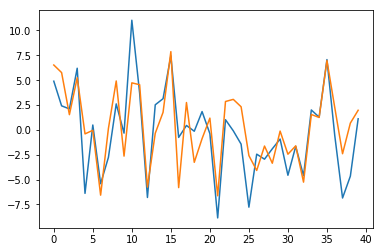

In [21]:
import matplotlib.pyplot as plt
ind = 3
indeces=numpy.arange(len(tru[-6:-1,:,ind].ravel()))
if ind == 3 or ind ==7 or ind ==11:
    plt.plot(indeces,tru[-6:-1,:,ind].ravel(),indeces,(pred[-6:-1,:,ind]*50).ravel())
else:
    plt.plot(indeces,tru[-6:-1,:,ind].ravel(),indeces,pred[-6:-1,:,ind].ravel())
plt.show()

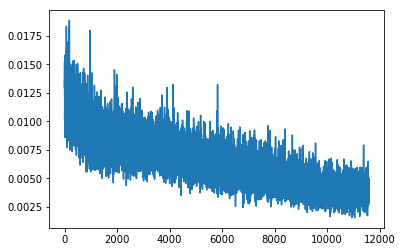

In [30]:
plt.plot(errorPlot[150:])
plt.show()

In [8]:
model.load_weights('model_weights'+saveNames+'.h5')

In [9]:
#validation test dataset - this time compare different brains with each other and look for MSE:
# transforms = numpy.genfromtxt('rand_affine_transforms_small_5std_5mu.csv', delimiter=',')
i=0
p = Path('/nfs01/data/FS_Slim/MCIC') #brains
testDirectories = [x for x in p.iterdir() if x.is_dir()]
vSize=150 #4 pairs of images
inBatch=0
evenOdd = True
# testThestas=transforms[-(vSize):,3:15:4]
# nameString='saved_small_brains_mean5/MCIC-small-test-std5-mu5-64-'
while inBatch<vSize:
    fname1 = str(testDirectories[i])+'/mri/norm.mgz'
    if os.path.isfile(fname1):
        scan = numpy.array(nib.load(fname1).get_data())[::4,::4,::4]
        if numpy.count_nonzero(scan)!=0: # make sure skull strip is not blank
            inBatch+=1
            scan=numpy.expand_dims(numpy.expand_dims(scan, axis=0), axis=0)
            if evenOdd:
                if inBatch==1:
                    test2=scan
                else:
                    test2=numpy.append(test2,scan,axis=0)
            else:
                if inBatch==2:
                    test1=scan
                else:
                    test1=numpy.append(test1,scan, axis=0)
    i+=1
    evenOdd = not evenOdd

In [10]:
debug_orig=model.predict([test1,test2])
debug_orig[:,3:15:4]*=50

In [11]:
#test3 is the validation
offset = [debug_orig[0,3],debug_orig[0,7],debug_orig[0,11]]
test3=numpy.squeeze(affine_transform(test1[0,0],[debug_orig[0,0:3],debug_orig[0,4:7],debug_orig[0,8:11]],offset=offset))[numpy.newaxis]
for i in range(1,len(test1)):
    offset = [debug_orig[i,3],debug_orig[i,7],debug_orig[i,11]]
    test3=numpy.append(test3,numpy.squeeze(affine_transform(test1[i,0],[debug_orig[i,0:3],debug_orig[i,4:7],debug_orig[i,8:11]],offset=offset))[numpy.newaxis],axis=0)


In [20]:
ind=28
print(numpy.sum((test1[ind,0].astype('float')-test2[ind,0].astype('float'))**2))
print(numpy.sum((test2[ind,0].astype('float')-test3[ind].astype('float'))**2))

65268210.0
45240942.0


In [12]:
cumsumOrigGraph=[]
cumsumNewGraph=[]
for ind in range(75):
    cumsumOrigGraph.append(numpy.sum((test1[ind,0].astype('float')-test2[ind,0].astype('float'))**2))
    cumsumNewGraph.append(numpy.sum((test2[ind,0].astype('float')-test3[ind].astype('float'))**2))
cumsumOrig=sum(cumsumOrigGraph)
cumsumNew=sum(cumsumNewGraph)

In [13]:
print((cumsumNew-cumsumOrig)/cumsumOrig)

-0.162135868499


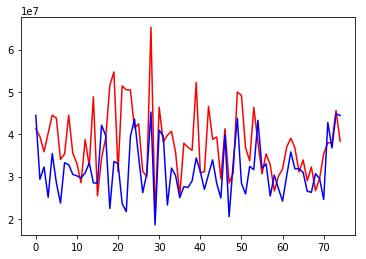

In [15]:
plt.plot(numpy.arange(len(cumsumOrigGraph)),cumsumOrigGraph,'r',cumsumNewGraph,'b')

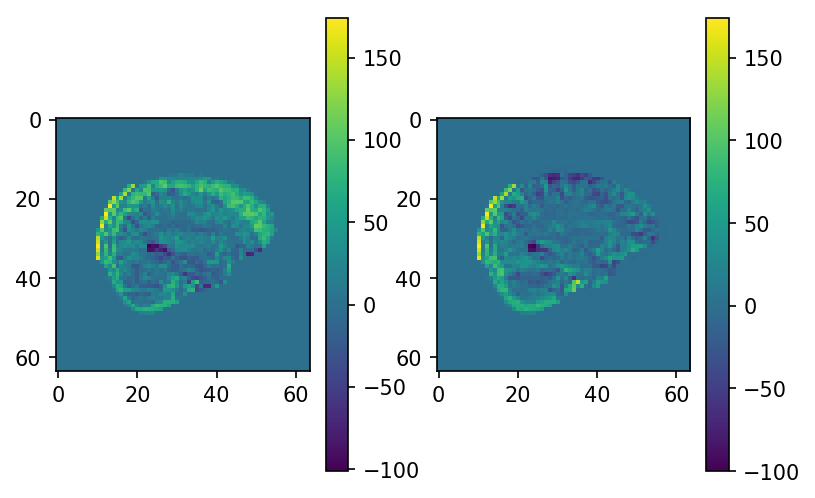

In [27]:
ind=28
zCoord = 40
plt.figure(dpi=150)
plt.subplot(121)
plt.imshow(test2[ind,0,zCoord].astype('float')-test1[ind,0,zCoord].astype('float'))
plt.colorbar()
plt.subplot(122)
plt.imshow(test2[ind,0,zCoord].astype('float')-test3[ind,zCoord].astype('float'))
plt.colorbar()